# Force Oscillation

<!-- This notebook will show how to do a transient simulation with given scheduling results. -->

In [1]:
import andes

import matplotlib.pyplot as plt

In [2]:
!andes misc --version

Python  3.12.0
andes   1.9.3.post21.dev0+g37040896
numpy   2.2.5
kvxopt  1.3.2.1
sympy   1.14.0
scipy   1.13.1
pandas  2.2.3
numba   0.61.2


In [3]:
%matplotlib inline

In [4]:
andes.config_logger(stream_level=30)

Two-Area System [1]

More info can be found at:
<https://electricgrids.engr.tamu.edu/electric-grid-test-cases/two-area-system/>

1. Prabha Kundur. Power System Stability and Control. McGraw-Hill Professional, 1994.

In [5]:
s1 = andes.load(andes.get_case('kundur/kundur_full.xlsx'),
                setup=False, no_output=True, default_config=True)

s1.COI.add(idx='COI_1')
s1.COI.add(idx='COI_2')

# hard code COI to generators
s1.GENROU.coi.v = ['COI_1'] * 2 + ['COI_2'] * 2

# turn off the line trip
s1.Toggle.set(src='u', attr='v', idx=1, value=0)
# add a Toggle to trip generator
s1.Toggle.add(idx=2, model='GENROU', dev=3, t=1)

s1.setup()

Generating code for 1 models on 12 processes.


True

One tie line is tripped at 2s.

In [6]:
s1.TDS.config.tf = 30
s1.TDS.config.no_tqdm = True
s1.TDS.config.criteria = 0

s1.PFlow.run()

_ = s1.TDS.init()

In [7]:
s1.TDS.run()

<Toggle 2>: GENROU.3 status changed to 0 at t=1.0 sec.


True

There are damped 0.625 Hz oscillation after the disturbance in both cases.

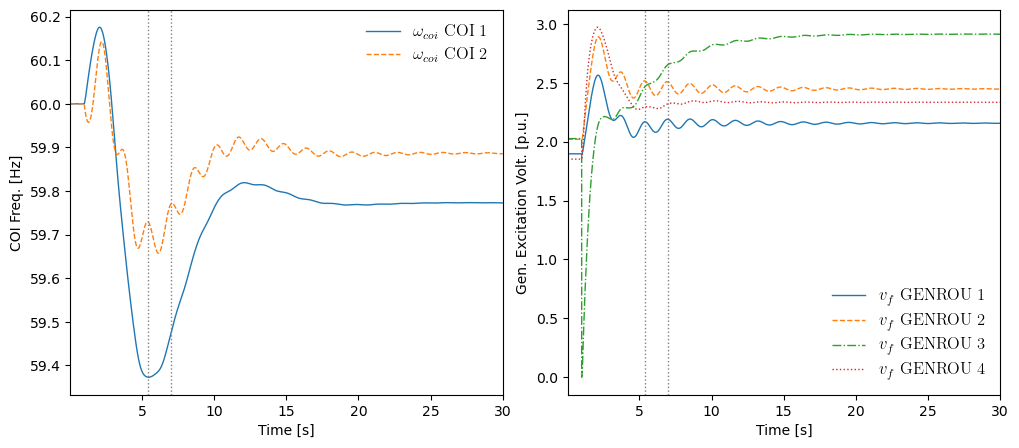

In [21]:
plt.style.use(['default'])
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
plt.subplots_adjust(hspace=0.2, wspace=0.15)

vline = [5.4, 7.0]
_ = s1.TDS.plt.plot(s1.COI.omega,
                    ytimes=s1.config.freq,
                    grid=False, show=False,
                    vline=vline,
                    fig=fig, ax=ax[0],
                    ylabel='COI Freq. [Hz]')
_ = s1.TDS.plt.plot(s1.GENROU.vf,
                    grid=False, show=False,
                    vline=vline,
                    fig=fig, ax=ax[1],
                    ylabel='Gen. Excitation Volt. [p.u.]')